In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
import optuna
from datetime import datetime, timedelta
import humanize
from sklearn.tree import plot_tree

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
random_state = 42

In [3]:
# Set default font
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.weight"] = 'semibold'

bold = 'extra bold'

sns.set(font=font_prop.get_name(), style='darkgrid')

## Model

We are going to use the following train-test split:
- 60% training set to train the model
- 20% validation set to tune the hyperparameters
- 20% test set to evaluate the model after tuning

In [4]:
X, y = load_iris(return_X_y=True)

In [5]:
y = np.where(y == 0, 0, 1)

In [6]:
data = load_breast_cancer()
X, y = data.data, data.target

In [7]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
        X,
        y,
        test_size=0.20,
        stratify=y,
        random_state=random_state
        )

X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.25,
        stratify=y_train_val,
        random_state=random_state
        )

In [9]:
def run_study(objective, n_trials=50, direction='maximize'):
    started_at = datetime.now()

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    ended_at = datetime.now()

    duration_in_seconds = (ended_at - started_at).total_seconds()

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    print("Time taken:", humanize.naturaldelta(timedelta(seconds=duration_in_seconds)))

    return study, duration_in_seconds

In [10]:
def trial_evaluation_metric(y_true, y_pred):
    return metrics.precision_score(y_true, y_pred)
    # return metrics.recall_score(y_true, y_pred)
    # return metrics.f1_score(y_true, y_pred)
    # return metrics.fbeta_score(y_true, y_pred, beta=10)

In [11]:
def objective_dt(trial):
    params = {
            'max_depth': trial.suggest_int("max_depth", 1, 20),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'random_state': random_state
            }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [12]:
def objective_rf(trial):
    params = {
            'n_estimators': trial.suggest_int("n_estimators", 10, 300),
            'max_depth': trial.suggest_int("max_depth", 1, 30),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'random_state': random_state
            }


    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [13]:
def objective_xgb(trial):
    params = {
            'n_estimators': trial.suggest_int("n_estimators", 50, 500),
            'max_depth': trial.suggest_int("max_depth", 3, 15),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            'subsample': trial.suggest_float("subsample", 0.5, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
            'gamma': trial.suggest_float("gamma", 0, 5),
            'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),
            'reg_lambda': trial.suggest_float("reg_lambda", 0, 10),
            'random_state': random_state,
            }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [34]:
dt_study, dt_execution_seconds = run_study(objective_dt, n_trials=50)

[I 2025-03-02 12:46:32,701] A new study created in memory with name: no-name-37a44e2b-ec7d-46be-8d22-0f545deb68e6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-02 12:46:32,721] Trial 0 finished with value: 0.9696969696969697 and parameters: {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9696969696969697.
[I 2025-03-02 12:46:32,730] Trial 1 finished with value: 0.9571428571428572 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.9696969696969697.
[I 2025-03-02 12:46:32,738] Trial 2 finished with value: 0.9583333333333334 and parameters: {'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.9696969696969697.
[I 2025-03-02 12:46:32,747] Trial 3 finished with value: 0.9444444444444444 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.9696969696969697.
[I 2025-03-02 12:46:32,755] Trial 4 finished with value: 0.9696969696969697 and param

[I 2025-03-02 12:46:33,363] Trial 37 finished with value: 0.9710144927536232 and parameters: {'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 34 with value: 0.9710144927536232.
[I 2025-03-02 12:46:33,385] Trial 38 finished with value: 0.9444444444444444 and parameters: {'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 34 with value: 0.9710144927536232.
[I 2025-03-02 12:46:33,406] Trial 39 finished with value: 0.9714285714285714 and parameters: {'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 39 with value: 0.9714285714285714.
[I 2025-03-02 12:46:33,428] Trial 40 finished with value: 0.9714285714285714 and parameters: {'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 39 with value: 0.9714285714285714.
[I 2025-03-02 12:46:33,450] Trial 41 finished with value: 0.9714285714285714 and p

In [35]:
rf_study, rf_execution_seconds = run_study(objective_rf, n_trials=50)

[I 2025-03-02 12:46:35,036] A new study created in memory with name: no-name-4638d064-e82b-45ca-baa5-50e30130ec6a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-02 12:46:35,135] Trial 0 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 67, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.9452054794520548.
[I 2025-03-02 12:46:35,420] Trial 1 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 101, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9452054794520548.
[I 2025-03-02 12:46:35,844] Trial 2 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 180, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9452054794520548.
[I 2025-03-02 12:46:36,111] Trial 3 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 97, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_fea

[I 2025-03-02 12:46:41,040] Trial 31 finished with value: 0.9583333333333334 and parameters: {'n_estimators': 211, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 4 with value: 0.9583333333333334.
[I 2025-03-02 12:46:41,315] Trial 32 finished with value: 0.9577464788732394 and parameters: {'n_estimators': 239, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 4 with value: 0.9583333333333334.
[I 2025-03-02 12:46:41,536] Trial 33 finished with value: 0.9583333333333334 and parameters: {'n_estimators': 179, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 4 with value: 0.9583333333333334.
[I 2025-03-02 12:46:42,204] Trial 34 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 271, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 5,

In [36]:
xgb_study, xgb_execution_seconds = run_study(objective_xgb, n_trials=50)

[I 2025-03-02 12:46:45,863] A new study created in memory with name: no-name-0434e9f7-2137-4d59-9efa-667cba995b2c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-02 12:46:46,020] Trial 0 finished with value: 0.9452054794520548 and parameters: {'n_estimators': 455, 'max_depth': 5, 'learning_rate': 0.27995429498123314, 'subsample': 0.7787889234842518, 'colsample_bytree': 0.9678484653026798, 'gamma': 3.625940337541979, 'reg_alpha': 4.302256757348861, 'reg_lambda': 8.399916565833815}. Best is trial 0 with value: 0.9452054794520548.
[I 2025-03-02 12:46:46,121] Trial 1 finished with value: 0.971830985915493 and parameters: {'n_estimators': 413, 'max_depth': 7, 'learning_rate': 0.03765260273115675, 'subsample': 0.612799881741167, 'colsample_bytree': 0.92072585966595, 'gamma': 2.657289258055235, 'reg_alpha': 0.9710808939729265, 'reg_lambda': 1.0767482125081185}. Best is trial 1 with value: 0.971830985915493.
[I 2025-03-02 12:46:46,259] Trial 2 finished with value: 0.9583333333333334 and parameters: {'n_estimators': 367, 'max_depth': 10, 'learning_rate': 0.010653120179888611, 'subsample': 0.8048826804563096, 'colsample_bytree': 0.719136116370

[I 2025-03-02 12:46:48,254] Trial 23 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 465, 'max_depth': 5, 'learning_rate': 0.027491824902529223, 'subsample': 0.6263299270153455, 'colsample_bytree': 0.78721263983841, 'gamma': 1.4596939676779814, 'reg_alpha': 2.082631019657751, 'reg_lambda': 0.09804478705236064}. Best is trial 14 with value: 0.9722222222222222.
[I 2025-03-02 12:46:48,365] Trial 24 finished with value: 0.9583333333333334 and parameters: {'n_estimators': 322, 'max_depth': 5, 'learning_rate': 0.018185923550305856, 'subsample': 0.6373473537849691, 'colsample_bytree': 0.7955455373105997, 'gamma': 1.4828681764753182, 'reg_alpha': 2.6521117127636185, 'reg_lambda': 2.6009155295112256}. Best is trial 14 with value: 0.9722222222222222.
[I 2025-03-02 12:46:48,491] Trial 25 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.04491844930298813, 'subsample': 0.5430113355188024, 'colsample_bytree': 0.

[I 2025-03-02 12:46:51,177] Trial 46 finished with value: 0.9577464788732394 and parameters: {'n_estimators': 389, 'max_depth': 4, 'learning_rate': 0.026278257959348926, 'subsample': 0.9509699674186498, 'colsample_bytree': 0.6927588637186471, 'gamma': 0.31088667686670035, 'reg_alpha': 4.018746050307578, 'reg_lambda': 5.8771402415928495}. Best is trial 14 with value: 0.9722222222222222.
[I 2025-03-02 12:46:51,313] Trial 47 finished with value: 0.971830985915493 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.043236870074225726, 'subsample': 0.8156334636000243, 'colsample_bytree': 0.6503669787575175, 'gamma': 0.010451870346737335, 'reg_alpha': 0.06333989862756462, 'reg_lambda': 4.185420399234884}. Best is trial 14 with value: 0.9722222222222222.
[I 2025-03-02 12:46:51,533] Trial 48 finished with value: 0.9459459459459459 and parameters: {'n_estimators': 483, 'max_depth': 11, 'learning_rate': 0.02406531375491733, 'subsample': 0.6179199394737265, 'colsample_bytree'

In [37]:
# create a df with the results
df_results = pd.DataFrame({
    'model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'evaluation_metric': [
        dt_study.best_value,
        rf_study.best_value,
        xgb_study.best_value
        ],
    'execution_seconds': [
        dt_execution_seconds,
        rf_execution_seconds,
        xgb_execution_seconds
        ]
    })

In [38]:
df_results

,model,evaluation_metric,execution_seconds
0,Decision Tree,0.97,0.93
1,Random Forest,0.96,10.82
2,XGBoost,0.97,5.83


In [39]:
# calculate accuracy, precision, recall and f1-score
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    return accuracy, precision, recall, f1

In [40]:
best_dt = DecisionTreeClassifier(**dt_study.best_params)
best_rf = RandomForestClassifier(**rf_study.best_params)
best_xgb = XGBClassifier(**xgb_study.best_params)

best_dt.fit(X_train_val, y_train_val)
best_rf.fit(X_train_val, y_train_val)
best_xgb.fit(X_train_val, y_train_val)

print()

In [41]:
# calculate metrics
dt_metrics = calculate_metrics(best_dt, X_test, y_test)
rf_metrics = calculate_metrics(best_rf, X_test, y_test)
xgb_metrics = calculate_metrics(best_xgb, X_test, y_test)

In [42]:
model_metrics = np.array([dt_metrics, rf_metrics, xgb_metrics]).transpose()
model_metrics

array([[0.94736842, 0.94736842, 0.94736842],
       [0.95833333, 0.95833333, 0.95833333],
       [0.95833333, 0.95833333, 0.95833333],
       [0.95833333, 0.95833333, 0.95833333]])

In [43]:
df_results['accuracy'] = model_metrics[0]
df_results['precision'] = model_metrics[1]
df_results['recall'] = model_metrics[2]
df_results['f1'] = model_metrics[3]

In [44]:
df_results

,model,evaluation_metric,execution_seconds,accuracy,precision,recall,f1
0,Decision Tree,0.97,0.93,0.95,0.96,0.96,0.96
1,Random Forest,0.96,10.82,0.95,0.96,0.96,0.96
2,XGBoost,0.97,5.83,0.95,0.96,0.96,0.96


In [45]:
def roc_curve_metrics(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)

    return fpr, tpr, thresholds, auc

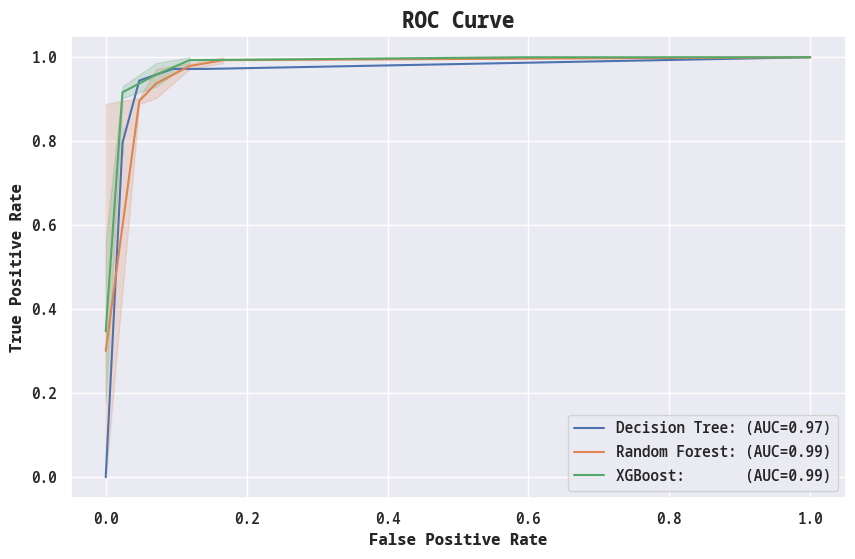

In [46]:
# plot auc with hue as model
fig, ax = plt.subplots(figsize=(10, 6))

viz_df = pd.DataFrame(columns=['model', 'fpr', 'tpr', 'auc', 'thresholds'])

max_legend_length = max([len(model + ': ') for model in df_results['model']])

fpr, tpr, thresholds, auc = roc_curve_metrics(best_dt, X_test, y_test)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'Decision Tree: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

fpr, tpr, thresholds, auc = roc_curve_metrics(best_rf, X_test, y_test)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'Random Forest: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

fpr, tpr, thresholds, auc = roc_curve_metrics(best_xgb, X_test, y_test)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'XGBoost: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

ax.set_xlabel('False Positive Rate', fontweight=bold)
ax.set_ylabel('True Positive Rate', fontweight=bold)

plt.title('ROC Curve', fontweight=bold, fontsize=16)

plt.show()

Similar AUC for all models, very minor difference for decision trees. Same for the f1 score for which we optimized.
<br />
We can use the decision tree model to also take advantage of the interpretability.

In [47]:
dt_study.best_params

{'max_depth': 9,
 'min_samples_split': 19,
 'min_samples_leaf': 8,
 'criterion': 'gini'}

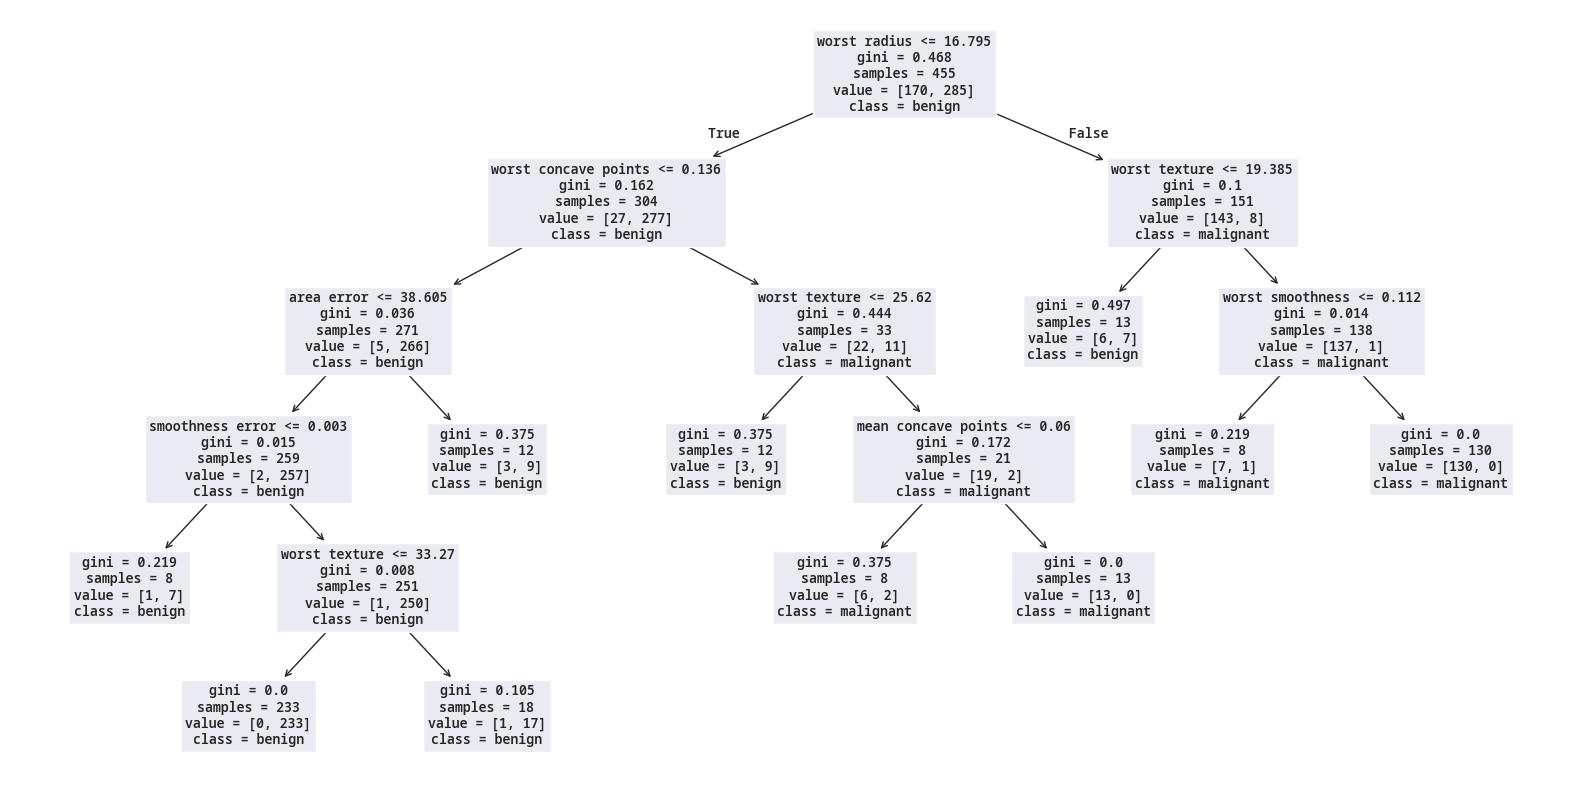

In [48]:
# print the tree

plt.figure(figsize=(20, 10))

plot_tree(
        best_dt,
        feature_names=data.feature_names,
        class_names=data.target_names,
        )

plt.show()

In [49]:
def color_confusion_matrix_annotations(cm, ax, i, j):
    # Get the colormap used in the plot
    cmap = ax.images[0].cmap
    norm = ax.images[0].norm

    # See https://github.com/scikit-learn/scikit-learn/blob/99bf3d8e4/sklearn/metrics/_plot/confusion_matrix.py#L159
    # print text with appropriate color depending on background
    thresh = (cm.max() + cm.min()) / 2.0

    cmap_max = cmap(norm(cm.max()))
    cmap_min = cmap(norm(cm.min()))

    color = cmap_max if cm[i, j] < thresh else cmap_min

    return color

In [104]:
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X)

    cm = metrics.confusion_matrix(y, y_pred)
    disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=data.target_names
            )

    fig, ax = plt.subplots(
            nrows=1, ncols=1,
            figsize=(4, 3),
            dpi=200
            )

    disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=data.target_names,
            )

    disp.plot(ax=ax, values_format='.0f', cmap='Oranges')

    # remove grid lines
    ax.grid(False)

    annotations = [
        ["True Negative", "False Positive"],
        ["False Negative", "True Positive"],
    ]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i - 0.2,  # Slightly above the center
                annotations[i][j],
                ha="center", va="center",
                fontsize=9,
                color=color_confusion_matrix_annotations(cm, ax, i, j)
            )

    # change tick font size
    ax.tick_params(axis='both', which='major', labelsize=9)

    report = metrics.classification_report(y, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).T.round(3)

    ax.set_title(type(model).__name__, fontweight=bold, fontsize=13)

    ax.set_xlabel('Predicted label', fontweight=bold)
    ax.set_ylabel('True label', fontweight=bold)

    plt.show()

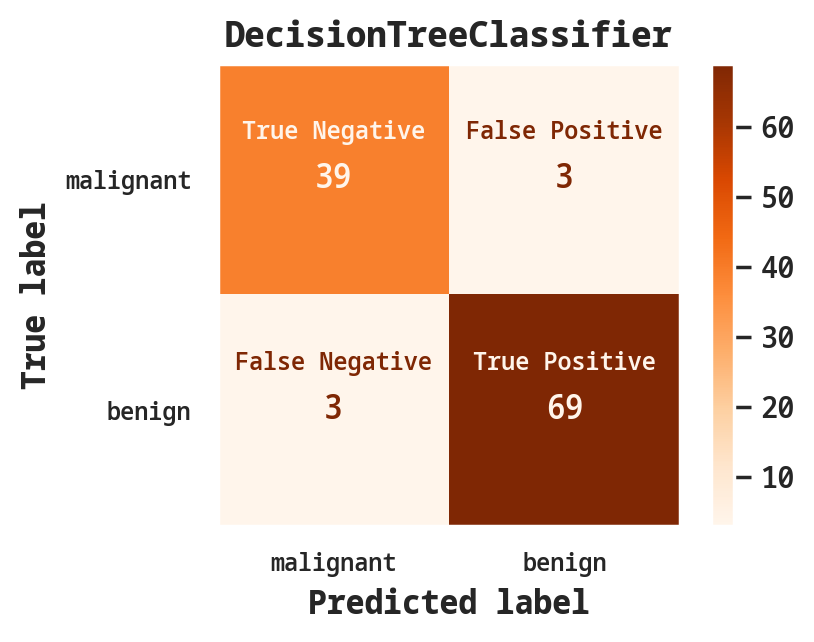

In [105]:
plot_confusion_matrix(best_dt, X_test, y_test)

Given that `False Negatives` have a big impact, we could look into the other models. Even a small improvement in this metric makes a difference.

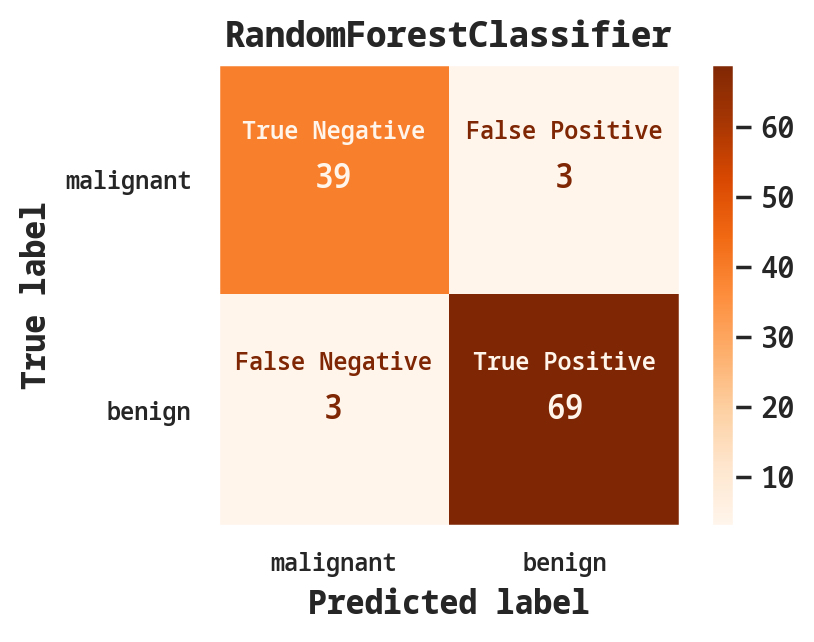

In [106]:
plot_confusion_matrix(best_rf, X_test, y_test)

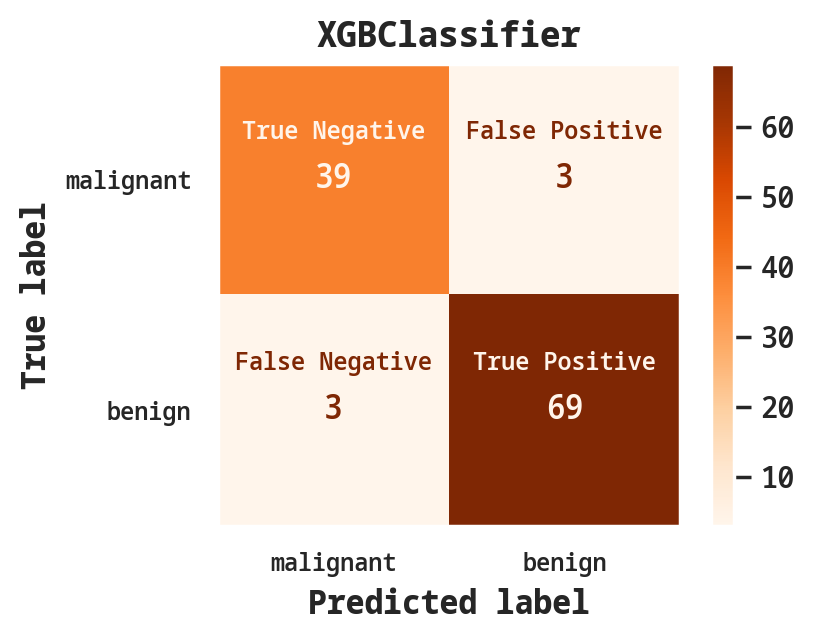

In [107]:
plot_confusion_matrix(best_xgb, X_test, y_test)

The models have the same performance when it comes to the `False Negatives` as well.
<br />
The Decision Tree model offers interpretability. Random Forest and XGBoost have the same performance but are slightly more robust as shown by the AUC above.
<br />
Since this concerns health, we could use either the Random Forest or the XGBoost model.